**Stock Market Prediction System**

First we'll gather the stock data for five stock ticker, that are APPL, AMZN, GOOG, FB, and TSLA. The idea is to create/find a data set that has news article headlines of these stock or company, then perform sentiment analysis, then gather the stock prices from the historic data, finding corelation and lastly applying ML model on the data for future prediction.

We'll use Beautifulsoup in Python to scrape article headlines of the mentioned stock ticker from FinViz. Next up, we will extract our historic stock data from Yahoo Finance using the yfinance library.

In [ ]:
# Import Packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

In [ ]:
finviz_url = 'https://finviz.com/quote.ashx?t='
companies = ['AAPL','AMZN', 'GOOG', 'FB', 'TSLA']

news_tables = {}
parsed_data = []

for company in companies:
    url = finviz_url + company

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[company] = news_table

In [ ]:
# Iterate through the news
for company, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([company, date, time, title])

news_df = pd.DataFrame(parsed_data, columns=['Company', 'Date', 'Time', 'News Headline'])
news_df['Date'] = pd.to_datetime(news_df.Date).dt.date

In [ ]:
news_df.head()

,Company,Date,Time,News Headline
0,AAPL,2021-07-17,10:13AM,Ive used Apple AirPods for years now. Heres wh...
1,AAPL,2021-07-17,08:21AM,"How HBO Max, Netflix, Disney+ secured 'dominan..."
2,AAPL,2021-07-17,08:00AM,Is This Apple Supplier a Buy Before Its Next E...
3,AAPL,2021-07-17,07:00AM,"Big Contrarian Investor Sold Apple, Microsoft ..."
4,AAPL,2021-07-16,07:22PM,Tech Earnings Start Monday. Here Are 5 Trends ...


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        500 non-null    object
 1   Date           500 non-null    object
 2   Time           500 non-null    object
 3   News Headline  500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


In [ ]:
news_df['Company'].unique()

array(['AAPL', 'AMZN', 'GOOG', 'FB', 'TSLA'], dtype=object)

In [ ]:
news_df['Date'].unique()

array([datetime.date(2021, 7, 17), datetime.date(2021, 7, 16),
       datetime.date(2021, 7, 15), datetime.date(2021, 7, 14),
       datetime.date(2021, 7, 13), datetime.date(2021, 7, 12),
       datetime.date(2021, 7, 11), datetime.date(2021, 7, 10),
       datetime.date(2021, 7, 9), datetime.date(2021, 7, 8),
       datetime.date(2021, 7, 7)], dtype=object)

In [ ]:
# Clean the News Headline text data using regex expressions
import re

def clean_text(text):
  lower_case = text.lower() #lower the case
  remove_url = re.sub(r"https\S+","",lower_case) 
  remove_hash = re.sub(r"#\w*","",remove_url)
  remove_punctuation = re.sub(r'[^\w\s]','',remove_hash)
  remove_gt = remove_punctuation.replace("&gt","",True)
  remove_amp = remove_gt.replace('&amp','',True)
  clean = remove_amp
  return clean

news_df['News Headline'] = news_df['News Headline'].apply(clean_text)

In [ ]:
pip install flair

     |████████████████████████████████| 286kB 5.2MB/s 
     |████████████████████████████████| 19.7MB 1.3MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 798kB 40.5MB/s 
     |████████████████████████████████| 1.2MB 24.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 2.5MB 32.7MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 983kB 48.4MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 3.3MB 34.2MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9705 sha256=f94b24bd5afb747d52003bc263a8543d71a27ab250463d462e821b5ebd06a826
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Success

In [ ]:
#Now we need to tokenize our text by passing it through flair.data.Sentence(<TEXT HERE>) and calling the .predict method on our model.
# we then call score to get our confidence/probability score, and value for the POSITIVE/NEGATIVE prediction:

# pip install flair
# If you have issues installing Flair, it is due to your PyTorch/Tensorflow installations. Go to work in Google Colab

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2021-07-17 11:16:46,175 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
probability = []
sentiments = []

for text in news_df['News Headline'].to_list():
    # make prediction
    sentence = flair.data.Sentence(text)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probability.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# add probability and sentiment predictions to tweets dataframe
news_df['Sentiment'] = sentiments
news_df['Probability'] = probability

news_df.head(3)

,Company,Date,Time,News Headline,Sentiment,Probability
0,AAPL,2021-07-17,10:13AM,ive used apple airpods for years now heres wha...,POSITIVE,0.986938
1,AAPL,2021-07-17,08:21AM,how hbo max netflix disney secured dominance o...,POSITIVE,0.986208
2,AAPL,2021-07-17,08:00AM,is this apple supplier a buy before its next e...,NEGATIVE,0.986854


create a function to get sentiment scores (neg, pos, neu, & compound). 
The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
Pos is the positive percentage score, neg is the negative percentage score, and neu is the neutral percentage score.
The total for %pos + %neg + %neu = 100%

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 5.2MB/s 


In [ ]:
# first import libraries
# With NLTK (Natural Language Toolkit) comes a beautiful submodule called vader that allows us to pass in a string into its function 
# and get back the (neg, pos, neu, & compound)
import nltk
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #must have pip install vaderSentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#function to get the sentiment scores (using Sentiment Intensity Analyzer)
def getSIA(text):
  analyzer = SentimentIntensityAnalyzer()
  sentiment = analyzer.polarity_scores(text)
  return sentiment

In [ ]:
#Get the sentiment scores #for each day

compound = []
neg = []
neu = []
pos = []
SIA = 0
for i in range(0, len(news_df['News Headline'])):
  SIA = getSIA(news_df['News Headline'][i])
  compound.append(SIA['compound'])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

#Store the sentiment scores in the data frame
news_df['Negative'] =neg
news_df['Neutral'] =neu
news_df['Positive'] = pos
news_df['Compound'] =compound

news_df.head() 
# Here is we done with the very fine sentiment analysis

,Company,Date,Time,News Headline,Sentiment,Probability,Negative,Neutral,Positive,Compound
0,AAPL,2021-07-17,10:13AM,ive used apple airpods for years now heres wha...,POSITIVE,0.986938,0.0,0.757,0.243,0.7269
1,AAPL,2021-07-17,08:21AM,how hbo max netflix disney secured dominance o...,POSITIVE,0.986208,0.0,0.690,0.310,0.5423
2,AAPL,2021-07-17,08:00AM,is this apple supplier a buy before its next e...,NEGATIVE,0.986854,0.0,1.000,0.000,0.0000
3,AAPL,2021-07-17,07:00AM,big contrarian investor sold apple microsoft s...,NEGATIVE,0.998000,0.0,1.000,0.000,0.0000
4,AAPL,2021-07-16,07:22PM,tech earnings start monday here are 5 trends t...,POSITIVE,0.984099,0.0,1.000,0.000,0.0000


<Figure size 1080x720 with 0 Axes>

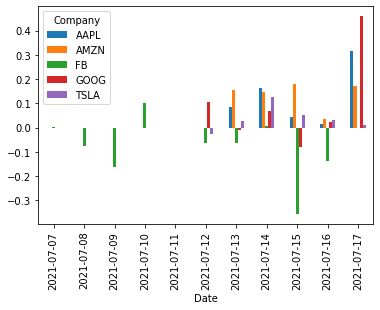

In [ ]:
# Let visualize this data to see how our Stocks fared every day from public perception in news articles.
# Let's visualize the results in a bar chart, by grouping the data based on the stock_company and dates:
plt.figure(figsize=(15,10))
df_plt = news_df.groupby(['Company', 'Date']).mean().unstack() # .unstack() function helped us to unstack the company column.
df_plt = df_plt.xs('Compound', axis="columns").transpose() # .transpose() function helped us obtain the cross-section of compound in the columns axis.
df_plt.plot(kind='bar')
plt.show()

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 7.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=dd82851b6e499a106eeac604068c61b029057fbd243515126f9c9696d5cbdfda
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# Now we scarp our historic stock data of one year from yahoo finance ysisng yfinace library
# Here we will only store the close prcices of 5 mentioned stocks
import yfinance as yf # must have pip install yfinance
from statsmodels import api as sm

In [ ]:
companies = ['AAPL','AMZN', 'GOOG', 'FB', 'TSLA']
stock_list = []
for stock in companies:
  ticker = yf.Ticker(stock)
  returns = ticker.history(period="5y") # stock data for five year from today back into July 2016
  returns['returns'] =  returns['Close'] # Only store Close Column, we can store the whole stock data by skipping this line but we only need the Close price

  returns.rename(columns={'returns': stock}, inplace=True)
  returns = returns[stock]
  stock_list.append(returns)

all_stock_df =pd.DataFrame(stock_list).T
print(all_stock_df)

# if you want to save the file in your system in csv form
#all_stock_df.to_csv('Stocks_df') 

                  AAPL         AMZN         GOOG          FB        TSLA
Date                                                                    
2016-07-18   23.314920   736.070007   733.780029  119.370003   45.250000
2016-07-19   23.324263   739.950012   736.960022  120.610001   45.051998
2016-07-20   23.345284   745.719971   741.190002  121.919998   45.672001
2016-07-21   23.221504   744.429993   738.630005  120.610001   44.099998
2016-07-22   23.041672   744.859985   742.739990  121.000000   44.453999
...                ...          ...          ...         ...         ...
2021-07-12  144.500000  3718.550049  2611.280029  353.160004  685.700012
2021-07-13  145.639999  3677.360107  2619.889893  352.089996  668.539978
2021-07-14  149.149994  3681.679932  2641.649902  347.630005  653.380005
2021-07-15  148.479996  3631.199951  2625.330078  344.459991  650.599976
2021-07-16  146.389999  3573.629883  2636.909912  341.160004  644.219971

[1259 rows x 5 columns]


In [ ]:
# Now we want to compare the relationship between the stock returns and our sentiment score.
# Note that in our news_df there are just few dates articles so we now scrap the historic data accourding to the max and min dates of the news_df
# Saving this in a new DataFrame
#Also we calculate and store the daily return of each stock's close prices by dividing today’s prices by yesterday’s 
companies =['AAPL','AMZN','FB','GOOG','TSLA']
stock_list = []
for stock in companies:
  ticker = yf.Ticker(stock)
  returns = ticker.history(start=(news_df['Date'].min()).strftime('%Y-%m-%d'), end=news_df['Date'].max().strftime('%Y-%m-%d'))
  returns['returns'] =  returns['Close'] # just store Close
  returns['Daily_Return'] = returns['Close']/returns['Close'].shift(1) - 1 # calculate daily returns

  returns.rename(columns={'returns': stock+'_Close', 'Daily_Return': stock+'_Daily_Return'}, inplace=True)
  return1 = returns[stock+'_Close']
  return2 = returns[stock+'_Daily_Return']
  stock_list.append(return1)
  stock_list.append(return2)
  

all_stock_df2 =pd.DataFrame(stock_list).T
print(all_stock_df2)

            AAPL_Close  AAPL_Daily_Return  ...  TSLA_Close  TSLA_Daily_Return
Date                                       ...                               
2021-07-07  144.570007                NaN  ...  644.650024                NaN
2021-07-08  143.240005          -0.009200  ...  652.809998           0.012658
2021-07-09  145.110001           0.013055  ...  656.950012           0.006342
2021-07-12  144.500000          -0.004204  ...  685.700012           0.043763
2021-07-13  145.639999           0.007889  ...  668.539978          -0.025026
2021-07-14  149.149994           0.024100  ...  653.380005          -0.022676
2021-07-15  148.479996          -0.004492  ...  650.599976          -0.004255

[7 rows x 10 columns]


In [ ]:
# Aggregate daily sentiment scores by taking the max score in a particular day of a particular stock
news_df2 = news_df.groupby(['Company','Date']).max() # Aggregade
# Lagged the sentiment score
news_df2['Score'] = news_df2['Compound'].shift(1)
news_df2.head()

Time  ...   Score
Company Date                   ...        
AAPL    2021-07-13  11:22PM    ...     NaN
        2021-07-14  12:55PM    ...  0.3400
        2021-07-15  12:35PM    ...  0.7650
        2021-07-16  12:47AM    ...  0.6808
AMZN    2021-07-13  12:49PM    ...  0.6249

[5 rows x 9 columns]

In [ ]:
# To match the daily returns against the corresponding sentiment scores merge the df taking a particular stock
AAPL_merge_df = pd.merge(all_stock_df2[['AAPL_Daily_Return']], pd.DataFrame(news_df2.loc['AAPL']['Score']), left_index=True,right_index=True, how='left')
# replace NaN with 0 permanently
AAPL_merge_df.fillna(0, inplace=True) 
print(AAPL_merge_df)

            AAPL_Daily_Return  Score
Date                                
2021-07-07           0.000000  0.000
2021-07-08          -0.009200  0.000
2021-07-09           0.013055  0.000
2021-07-12          -0.004204  0.000
2021-07-13           0.007889  0.000
2021-07-14           0.024100  0.340
2021-07-15          -0.004492  0.765


In [ ]:
# AMZN
AMZN_merge_df = pd.merge(all_stock_df2[['AMZN_Daily_Return']], pd.DataFrame(news_df2.loc['AMZN']['Score']), left_index=True,right_index=True, how='left')
AMZN_merge_df.fillna(0, inplace=True)

# GOOG
GOOG_merge_df = pd.merge(all_stock_df2[['GOOG_Daily_Return']], pd.DataFrame(news_df2.loc['GOOG']['Score']), left_index=True,right_index=True, how='left')
GOOG_merge_df.fillna(0, inplace=True)

# FB
FB_merge_df = pd.merge(all_stock_df2[['FB_Daily_Return']], pd.DataFrame(news_df2.loc['FB']['Score']), left_index=True,right_index=True, how='left')
FB_merge_df.fillna(0, inplace=True)

# TSLA
TSLA_merge_df = pd.merge(all_stock_df2[['TSLA_Daily_Return']], pd.DataFrame(news_df2.loc['TSLA']['Score']), left_index=True,right_index=True, how='left')
TSLA_merge_df.fillna(0, inplace=True)

In [ ]:
# Check relationship (correlation) between lagged score against stock daily returns of all stocks
# merge_df.plot(x='Score', y='AAPL_Daily_Return', style='o')
AAPL_cor = AAPL_merge_df['AAPL_Daily_Return'].corr(AAPL_merge_df['Score']) 
print('Correlation of AAPL_daily return and AAPL sentiment score: ', AAPL_cor) # wooow very good correlation. SSo thats it

AMZN_cor = AMZN_merge_df['AMZN_Daily_Return'].corr(AMZN_merge_df['Score']) 
print('Correlation of AMZN_daily return and AMZN sentiment score: ', AMZN_cor)

GOOG_cor = GOOG_merge_df['GOOG_Daily_Return'].corr(GOOG_merge_df['Score']) 
print('Correlation of GOOG_daily return and GOOG sentiment score: ', GOOG_cor)

FB_cor = FB_merge_df['FB_Daily_Return'].corr(FB_merge_df['Score']) 
print('Correlation of FB_daily return and FB sentiment score: ', FB_cor)

TSLA_cor = TSLA_merge_df['TSLA_Daily_Return'].corr(TSLA_merge_df['Score']) 
print('Correlation of TSLA_daily return and TSLA sentiment score: ', TSLA_cor)

# Woow we got very good correlation score by the sentimental analysis 

Correlation of AAPL_daily return and AAPL sentiment score:  0.02257205564665253
Correlation of AMZN_daily return and AMZN sentiment score:  -0.5885816736959857
Correlation of GOOG_daily return and GOOG sentiment score:  0.15354469650827046
Correlation of FB_daily return and FB sentiment score:  -0.8029452544541351
Correlation of TSLA_daily return and TSLA sentiment score:  -0.2272453908756808


In [ ]:
# Now we want to apply ML algorithm on the all_stock_df 
# Lets see our all_stock_df first
print(all_stock_df)

                  AAPL         AMZN         GOOG          FB        TSLA
Date                                                                    
2016-07-18   23.314920   736.070007   733.780029  119.370003   45.250000
2016-07-19   23.324263   739.950012   736.960022  120.610001   45.051998
2016-07-20   23.345284   745.719971   741.190002  121.919998   45.672001
2016-07-21   23.221504   744.429993   738.630005  120.610001   44.099998
2016-07-22   23.041672   744.859985   742.739990  121.000000   44.453999
...                ...          ...          ...         ...         ...
2021-07-12  144.500000  3718.550049  2611.280029  353.160004  685.700012
2021-07-13  145.639999  3677.360107  2619.889893  352.089996  668.539978
2021-07-14  149.149994  3681.679932  2641.649902  347.630005  653.380005
2021-07-15  148.479996  3631.199951  2625.330078  344.459991  650.599976
2021-07-16  146.389999  3573.629883  2636.909912  341.160004  644.219971

[1259 rows x 5 columns]


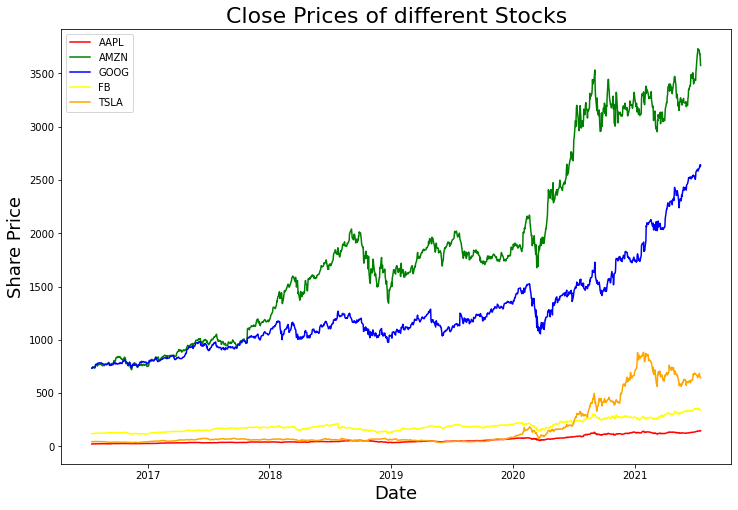

In [ ]:
# Now I plot the differents stocks data 
plt.figure(figsize=(12,8))
plt.plot(all_stock_df['AAPL'], color='red', label='AAPL')
plt.plot(all_stock_df['AMZN'], color='green', label='AMZN')
plt.plot(all_stock_df['GOOG'], color='blue', label='GOOG')
plt.plot(all_stock_df['FB'],color='yellow', label='FB')
plt.plot(all_stock_df['TSLA'], color='orange', label= 'TSLA')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Share Price',fontsize=18)
plt.title('Close Prices of different Stocks',fontsize=22)
plt.legend(loc=2)

**LSTM - Algorithm**

The algorithm here I will use for the stock price prediction is the LSTM, Long short Term Memory networks, that has been observed as the most effective solution in time series forcasting. Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data.
LSTM models are able to store information over a period of time
LSTMs have an edge over conventional feed-forward neural networks and RNN in many ways. This is because of their property of selectively remembering patterns for long durations of time.

Documentation:
https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler # for normalization
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from sklearn import metrics
import math

**AAPL Stock Prediction using LSTM**

In [ ]:
AAPL_df = pd.DataFrame(all_stock_df['AAPL'])
AAPL_df['AAPL'] = np.round(AAPL_df['AAPL'],2) # round the decimals
print(AAPL_df.head())

             AAPL
Date             
2016-07-18  23.31
2016-07-19  23.32
2016-07-20  23.35
2016-07-21  23.22
2016-07-22  23.04


In [ ]:
# Building the data
AAPL_dataset = AAPL_df.values
# len(AAPL_dataset) # 1258
AAPL_train_size = math.ceil(len(AAPL_dataset)*.8) # 80% of the total data
# Split the data into 80% train_dataset and 20% as test_dataset
AAPL_train_data = AAPL_dataset[0:AAPL_train_size,:]
#AAPL_test_data = AAPL_dataset[AAPL_train_size:,:]
# Normalize the data, this boost the performance of model
scaler = MinMaxScaler(feature_range=(0, 1))
AAPL_scaled_data = scaler.fit_transform(AAPL_dataset)

# since we are using LSTM, we must specify the shape of input as 3 dimensional which will be the samples, the time step and the features,
#Samples - This is the len(dataX), or the amount of data points you have.
# Time steps - This is the point of observation in the samples. This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60.
# Features - this is the amount of features in every time step which is the close price of stock in our case. so we seem to have 1 feature per time step.

AAPL_Xtrain, AAPL_ytrain = [], []
for i in range(60,len(AAPL_train_data)): # Seting Timestep to 60, so we need 60 observation of data from our train_data
    AAPL_Xtrain.append(AAPL_scaled_data[i-60:i,0])
    AAPL_ytrain.append(AAPL_scaled_data[i,0])
AAPL_Xtrain, AAPL_ytrain = np.array(AAPL_Xtrain), np.array(AAPL_ytrain)
AAPL_Xtrain = np.reshape(AAPL_Xtrain, (AAPL_Xtrain.shape[0],AAPL_Xtrain.shape[1],1)) 
print(AAPL_Xtrain.shape) # (Smaples, Timesteps, features)
print(AAPL_ytrain.shape) 

(948, 60, 1)
(948,)


In [ ]:
# Creating LSTM network
# I will build the LSTM with 3 hidden layers and 150 neurons in each layer. and lastly will assign 1 neuron in the output layer for predicting the normalized stock price. 
# I will use the MSE loss function and the Adam stochastic gradient descent optimizer.
AAPL_model = Sequential()
AAPL_model.add(LSTM(units=150, return_sequences=True, input_shape=(AAPL_Xtrain.shape[1],1))) # input_shape is (Timestep, Features)
AAPL_model.add(Dropout(0.2)) 
AAPL_model.add(LSTM(units=150, return_sequences=True))
#AAPL_model.add(Dropout(0.2))
AAPL_model.add(LSTM(units=150))
AAPL_model.add(Dense(1))

AAPL_model.compile(loss='mean_squared_error', optimizer='adam') # model compilation
AAPL_model.fit(AAPL_Xtrain, AAPL_ytrain, epochs=1, batch_size=10, verbose=2) # fit the model on the train data
# this will take time - Be patient - we want good accuracy - try diffeent values of the hyperparameters

95/95 - 41s - loss: 0.0021


In [ ]:
#predicting values
AAPL_test_data = AAPL_scaled_data[AAPL_train_size - 60:,:]
AAPL_Xtest = []
AAPL_ytest = AAPL_dataset[AAPL_train_size:, :]
for i in range(60,len(AAPL_test_data)):
    AAPL_Xtest.append(AAPL_test_data[i-60:i,0])
AAPL_Xtest = np.array(AAPL_Xtest)
AAPL_Xtest = np.reshape(AAPL_Xtest, (AAPL_Xtest.shape[0],AAPL_Xtest.shape[1],1)) # 3 Dimension as of Xtrain, (samples, timestep, features)
AAPL_price_pred = AAPL_model.predict(AAPL_Xtest) # predict close price of the Xtest
AAPL_price_pred = scaler.inverse_transform(AAPL_price_pred) # get values of prediction to inverse the transformation of the normalization

In [ ]:
# Performance Evaluation
print('AAPL')
AAPL_Accuracy = round(metrics.r2_score(AAPL_ytest,AAPL_price_pred) * 100, 2)
print('r2 score: {}%'.format(AAPL_Accuracy))
AAPL_mean_abs = round(metrics.mean_absolute_error(AAPL_ytest,AAPL_price_pred), 2)
print('Mean Absolute Error: {}'.format(AAPL_mean_abs))
#print('Mean Squared Error:', metrics.mean_squared_error(AAPL_ytest,AAPL_price_pred))
AAPL_rms = round(np.sqrt(metrics.mean_squared_error(AAPL_ytest,AAPL_price_pred)), 2)
print('Root Mean Squared Error: {}'.format(AAPL_rms))

AAPL
r2 score: 64.82%
Mean Absolute Error: 5.02
Root Mean Squared Error: 6.24


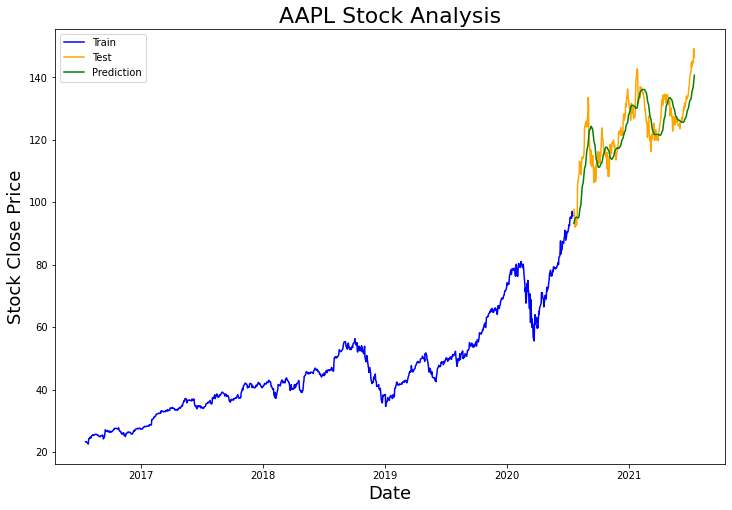

In [ ]:
# plotting
plt.figure(figsize=(12,8))
AAPL_train = AAPL_df[:AAPL_train_size]
AAPL_test = AAPL_df[AAPL_train_size:]
AAPL_test['Prediction'] = AAPL_price_pred
plt.plot(AAPL_train['AAPL'], c='blue', label='Train')
plt.plot(AAPL_test['AAPL'], c='orange',label='Test')
plt.plot(AAPL_test['Prediction'], c='green', label='Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Close Price',fontsize=18)
plt.title('AAPL Stock Analysis',fontsize=22)
plt.legend(loc=2)

**AMZN Stock Prediction using LSTM**

In [ ]:
AMZN_df = pd.DataFrame(all_stock_df['AMZN'])
AMZN_df['AMZN'] = np.round(AMZN_df['AMZN'],2) # round the decimals
print(AMZN_df.head())

              AMZN
Date              
2016-07-18  736.07
2016-07-19  739.95
2016-07-20  745.72
2016-07-21  744.43
2016-07-22  744.86


In [ ]:
# Building the data
AMZN_dataset = AMZN_df.values
# len(AMZN_dataset) # 1258
AMZN_train_size = math.ceil(len(AMZN_dataset)*.8) # 80% of the total data
# Split the data into 80% train_dataset and 20% as test_dataset
AMZN_train_data = AMZN_dataset[0:AMZN_train_size,:]
#AMZN_test_data = AMZN_dataset[AMZN_train_size:,:]
# Normalize the data, this boost the performance of model
scaler = MinMaxScaler(feature_range=(0, 1))
AMZN_scaled_data = scaler.fit_transform(AMZN_dataset)

# since we are using LSTM, we must specify the shape of input as 3 dimensional which will be the samples, the time step and the features,
AMZN_Xtrain, AMZN_ytrain = [], []
for i in range(60,len(AMZN_train_data)): # Seting Timestep to 60, so we need 60 observation of data from our train_data
    AMZN_Xtrain.append(AMZN_scaled_data[i-60:i,0])
    AMZN_ytrain.append(AMZN_scaled_data[i,0])
AMZN_Xtrain, AMZN_ytrain = np.array(AMZN_Xtrain), np.array(AMZN_ytrain)
AMZN_Xtrain = np.reshape(AMZN_Xtrain, (AMZN_Xtrain.shape[0],AMZN_Xtrain.shape[1],1)) 
print(AMZN_Xtrain.shape) # (Smaples, Timesteps, features)
print(AMZN_ytrain.shape) 

(948, 60, 1)
(948,)


In [ ]:
# Creating LSTM network
# I will build the LSTM with 3 hidden layers and 150 neurons in each layer. and lastly will assign 1 neuron in the output layer for predicting the normalized stock price. 
# I will use the MSE loss function and the Adam stochastic gradient descent optimizer.
AMZN_model = Sequential()
AMZN_model.add(LSTM(units=150, return_sequences=True, input_shape=(AMZN_Xtrain.shape[1],1))) # input_shape is (Timestep, Features)
AMZN_model.add(Dropout(0.2)) 
AMZN_model.add(LSTM(units=150, return_sequences=True))
#AMZN_model.add(Dropout(0.2))
AMZN_model.add(LSTM(units=150))
AMZN_model.add(Dense(1))

AMZN_model.compile(loss='mean_squared_error', optimizer='adam') # model compilation
AMZN_model.fit(AMZN_Xtrain, AMZN_ytrain, epochs=1, batch_size=10, verbose=2) # fit the model on the train data
# this will take time - Be patient - we want good accuracy

95/95 - 23s - loss: 0.0051


In [ ]:
#predicting values
AMZN_test_data = AMZN_scaled_data[AMZN_train_size - 60:,:]
AMZN_Xtest = []
AMZN_ytest = AMZN_dataset[AMZN_train_size:, :]
for i in range(60,len(AMZN_test_data)):
    AMZN_Xtest.append(AMZN_test_data[i-60:i,0])
AMZN_Xtest = np.array(AMZN_Xtest)
AMZN_Xtest = np.reshape(AMZN_Xtest, (AMZN_Xtest.shape[0],AMZN_Xtest.shape[1],1)) # 3 Dimension as of Xtrain, (samples, timestep, features)
AMZN_price_pred = AMZN_model.predict(AMZN_Xtest) # predict close price of the Xtest
AMZN_price_pred = scaler.inverse_transform(AMZN_price_pred) # get values of prediction to inverse the transformation of the normalization

In [ ]:
# Performance Evaluation
print('AMZN')
AMZN_Accuracy = round(metrics.r2_score(AMZN_ytest,AMZN_price_pred) * 100, 2)
print('r2 score: {}%'.format(AMZN_Accuracy))
AMZN_mean_abs = round(metrics.mean_absolute_error(AMZN_ytest,AMZN_price_pred), 2)
print('Mean Absolute Error: {}'.format(AMZN_mean_abs))
#print('Mean Squared Error:', metrics.mean_squared_error(AMZN_ytest,AMZN_price_pred))
AMZN_rms = round(np.sqrt(metrics.mean_squared_error(AMZN_ytest,AMZN_price_pred)), 2)
print('Root Mean Squared Error: {}'.format(AMZN_rms))

AMZN
r2 score: -33.07%
Mean Absolute Error: 142.58
Root Mean Squared Error: 174.88


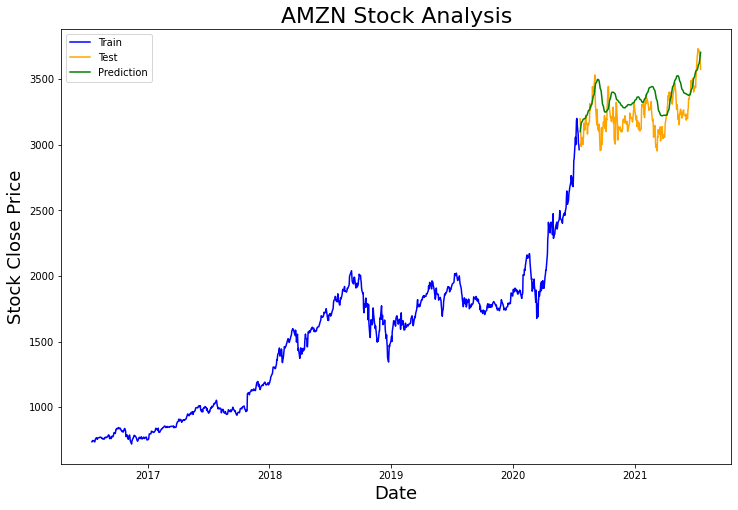

In [ ]:
# plotting
plt.figure(figsize=(12,8))
AMZN_train = AMZN_df[:AMZN_train_size]
AMZN_test = AMZN_df[AMZN_train_size:]
AMZN_test['Prediction'] = AMZN_price_pred
plt.plot(AMZN_train['AMZN'], c='blue', label='Train')
plt.plot(AMZN_test['AMZN'], c='orange', label='Test')
plt.plot(AMZN_test['Prediction'], c='green', label='Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Close Price',fontsize=18)
plt.title('AMZN Stock Analysis',fontsize=22)
plt.legend(loc=2)

**GOOG Stock Prediction Using LSTM**

In [ ]:
GOOG_df = pd.DataFrame(all_stock_df['GOOG'])
GOOG_df['GOOG'] = np.round(GOOG_df['GOOG'],2) # round the decimals
print(GOOG_df.head())

              GOOG
Date              
2016-07-18  733.78
2016-07-19  736.96
2016-07-20  741.19
2016-07-21  738.63
2016-07-22  742.74


In [ ]:
# Building the data
GOOG_dataset = GOOG_df.values
# len(GOOG_dataset) # 1258
GOOG_train_size = math.ceil(len(GOOG_dataset)*.8) # 80% of the total data
# Split the data into 80% train_dataset and 20% as test_dataset
GOOG_train_data = GOOG_dataset[0:GOOG_train_size,:]
#GOOG_test_data = GOOG_dataset[GOOG_train_size:,:]
# Normalize the data, this boost the performance of model
scaler = MinMaxScaler(feature_range=(0, 1))
GOOG_scaled_data = scaler.fit_transform(GOOG_dataset)

# since we are using LSTM, we must specify the shape of input as 3 dimensional which will be the samples, the time step and the features,
GOOG_Xtrain, GOOG_ytrain = [], []
for i in range(60,len(GOOG_train_data)): # Seting Timestep to 60, so we need 60 observation of data from our train_data
    GOOG_Xtrain.append(GOOG_scaled_data[i-60:i,0])
    GOOG_ytrain.append(GOOG_scaled_data[i,0])
GOOG_Xtrain, GOOG_ytrain = np.array(GOOG_Xtrain), np.array(GOOG_ytrain)
GOOG_Xtrain = np.reshape(GOOG_Xtrain, (GOOG_Xtrain.shape[0],GOOG_Xtrain.shape[1],1)) 
print(GOOG_Xtrain.shape) # (Smaples, Timesteps, features)
print(GOOG_ytrain.shape) 

(948, 60, 1)
(948,)


In [ ]:
# Creating LSTM network
# I will build the LSTM with 3 hidden layers and 150 neurons in each layer. and lastly will assign 1 neuron in the output layer for predicting the normalized stock price. 
# I will use the MSE loss function and the Adam stochastic gradient descent optimizer.
GOOG_model = Sequential()
GOOG_model.add(LSTM(units=150, return_sequences=True, input_shape=(GOOG_Xtrain.shape[1],1))) # input_shape is (Timestep, Features)
GOOG_model.add(Dropout(0.2)) 
GOOG_model.add(LSTM(units=150, return_sequences=True))
#GOOG_model.add(Dropout(0.2))
GOOG_model.add(LSTM(units=150))
GOOG_model.add(Dense(1))

GOOG_model.compile(loss='mean_squared_error', optimizer='adam') # model compilation
GOOG_model.fit(GOOG_Xtrain, GOOG_ytrain, epochs=1, batch_size=10, verbose=2) # fit the model on the train data
# this will take time - Be patient we want good accuracy

95/95 - 23s - loss: 0.0016


In [ ]:
#predicting values
GOOG_test_data = GOOG_scaled_data[GOOG_train_size - 60:,:]
GOOG_Xtest = []
GOOG_ytest = GOOG_dataset[GOOG_train_size:, :]
for i in range(60,len(GOOG_test_data)):
    GOOG_Xtest.append(GOOG_test_data[i-60:i,0])
GOOG_Xtest = np.array(GOOG_Xtest)
GOOG_Xtest = np.reshape(GOOG_Xtest, (GOOG_Xtest.shape[0],GOOG_Xtest.shape[1],1)) # 3 Dimension as of Xtrain, (samples, timestep, features)
GOOG_price_pred = GOOG_model.predict(GOOG_Xtest) # predict close price of the Xtest
GOOG_price_pred = scaler.inverse_transform(GOOG_price_pred) # get values of prediction to inverse the transformation of the normalization

In [ ]:
# Performance Evaluation
print('GOOG')
GOOG_Accuracy = round(metrics.r2_score(GOOG_ytest,GOOG_price_pred) * 100, 2)
print('r2 score: {}%'.format(GOOG_Accuracy))
GOOG_mean_abs = round(metrics.mean_absolute_error(GOOG_ytest,GOOG_price_pred), 2)
print('Mean Absolute Error: {}'.format(GOOG_mean_abs))
#print('Mean Squared Error:', metrics.mean_squared_error(GOOG_ytest,GOOG_price_pred))
GOOG_rms = round(np.sqrt(metrics.mean_squared_error(GOOG_ytest,GOOG_price_pred)), 2)
print('Root Mean Squared Error: {}'.format(GOOG_rms))

GOOG
r2 score: 87.82%
Mean Absolute Error: 104.21
Root Mean Squared Error: 126.19


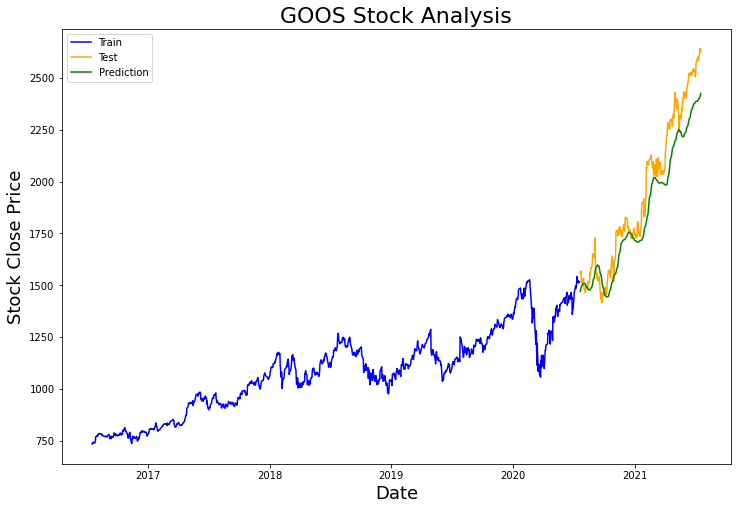

In [ ]:
# plotting
plt.figure(figsize=(12,8))
GOOG_train = GOOG_df[:GOOG_train_size]
GOOG_test = GOOG_df[GOOG_train_size:]
GOOG_test['Prediction'] = GOOG_price_pred
plt.plot(GOOG_train['GOOG'], c='blue', label='Train')
plt.plot(GOOG_test['GOOG'], c='orange', label='Test')
plt.plot(GOOG_test['Prediction'], c='green', label='Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Close Price',fontsize=18)
plt.title('GOOS Stock Analysis',fontsize=22)
plt.legend(loc=2)

**FB Stock Prediction Using LSTM**

In [ ]:
FB_df = pd.DataFrame(all_stock_df['FB'])
FB_df['FB'] = np.round(FB_df['FB'],2) # round the decimals
print(FB_df.head())

                FB
Date              
2016-07-18  119.37
2016-07-19  120.61
2016-07-20  121.92
2016-07-21  120.61
2016-07-22  121.00


In [ ]:
# Building the data
FB_dataset = FB_df.values
# len(FB_dataset) # 1258
FB_train_size = math.ceil(len(FB_dataset)*.8) # 80% of the total data
# Split the data into 80% train_dataset and 20% as test_dataset
FB_train_data = FB_dataset[0:FB_train_size,:]
#FB_test_data = FB_dataset[FB_train_size:,:]
# Normalize the data, this boost the performance of model
scaler = MinMaxScaler(feature_range=(0, 1))
FB_scaled_data = scaler.fit_transform(FB_dataset)

# since we are using LSTM, we must specify the shape of input as 3 dimensional which will be the samples, the time step and the features,
FB_Xtrain, FB_ytrain = [], []
for i in range(60,len(FB_train_data)): # Seting Timestep to 60, so we need 60 observation of data from our train_data
    FB_Xtrain.append(FB_scaled_data[i-60:i,0])
    FB_ytrain.append(FB_scaled_data[i,0])
FB_Xtrain, FB_ytrain = np.array(FB_Xtrain), np.array(FB_ytrain)
FB_Xtrain = np.reshape(FB_Xtrain, (FB_Xtrain.shape[0],FB_Xtrain.shape[1],1)) 
print(FB_Xtrain.shape) # (Smaples, Timesteps, features)
print(FB_ytrain.shape) 

(948, 60, 1)
(948,)


In [ ]:
# Creating LSTM network
# I will build the LSTM with 3 hidden layers and 150 neurons in each layer. and lastly will assign 1 neuron in the output layer for predicting the normalized stock price. 
# I will use the MSE loss function and the Adam stochastic gradient descent optimizer.
FB_model = Sequential()
FB_model.add(LSTM(units=150, return_sequences=True, input_shape=(FB_Xtrain.shape[1],1))) # input_shape is (Timestep, Features)
FB_model.add(Dropout(0.2)) 
FB_model.add(LSTM(units=150, return_sequences=True))
#FB_model.add(Dropout(0.2))
FB_model.add(LSTM(units=150))
FB_model.add(Dense(1))

FB_model.compile(loss='mean_squared_error', optimizer='adam') # model compilation
FB_model.fit(FB_Xtrain, FB_ytrain, epochs=1, batch_size=10, verbose=2) # fit the model on the train data
# this will take time - Be patient we want good accuracy

95/95 - 23s - loss: 0.0036


In [ ]:
#predicting values
FB_test_data = FB_scaled_data[FB_train_size - 60:,:]
FB_Xtest = []
FB_ytest = FB_dataset[FB_train_size:, :]
for i in range(60,len(FB_test_data)):
    FB_Xtest.append(FB_test_data[i-60:i,0])
FB_Xtest = np.array(FB_Xtest)
FB_Xtest = np.reshape(FB_Xtest, (FB_Xtest.shape[0],FB_Xtest.shape[1],1)) # 3 Dimension as of Xtrain, (samples, timestep, features)
FB_price_pred = FB_model.predict(FB_Xtest) # predict close price of the Xtest
FB_price_pred = scaler.inverse_transform(FB_price_pred) # get values of prediction to inverse the transformation of the normalization

In [ ]:
# Performance Evaluation
print('FB')
FB_Accuracy = round(metrics.r2_score(FB_ytest,FB_price_pred) * 100, 2)
print('r2 score: {}%'.format(FB_Accuracy))
FB_mean_abs = round(metrics.mean_absolute_error(FB_ytest,FB_price_pred), 2)
print('Mean Absolute Error: {}'.format(FB_mean_abs))
#print('Mean Squared Error:', metrics.mean_squared_error(FB_ytest,FB_price_pred))
FB_rms = round(np.sqrt(metrics.mean_squared_error(FB_ytest,FB_price_pred)), 2)
print('Root Mean Squared Error: {}'.format(FB_rms))

FB
r2 score: 84.45%
Mean Absolute Error: 9.33
Root Mean Squared Error: 11.66


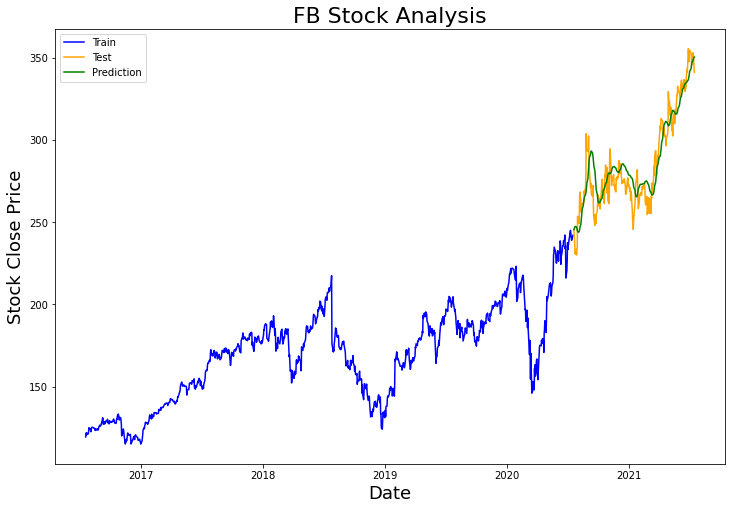

In [ ]:
# plotting
plt.figure(figsize=(12,8))
FB_train = FB_df[:FB_train_size]
FB_test = FB_df[FB_train_size:]
FB_test['Prediction'] = FB_price_pred
plt.plot(FB_train['FB'], c='blue', label='Train')
plt.plot(FB_test['FB'], c='orange', label='Test')
plt.plot(FB_test['Prediction'], c='green', label='Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Close Price',fontsize=18)
plt.title('FB Stock Analysis',fontsize=22)
plt.legend(loc=2)

**TSLA Stock Prediction Using LSTM**

In [ ]:
TSLA_df = pd.DataFrame(all_stock_df['TSLA'])
TSLA_df['TSLA'] = np.round(TSLA_df['TSLA'],2) # round the decimals
print(TSLA_df.head())

             TSLA
Date             
2016-07-18  45.25
2016-07-19  45.05
2016-07-20  45.67
2016-07-21  44.10
2016-07-22  44.45


In [ ]:
# Building the data
TSLA_dataset = TSLA_df.values
# len(TSLA_dataset) # 1258
TSLA_train_size = math.ceil(len(TSLA_dataset)*.8) # 80% of the total data
# Split the data into 80% train_dataset and 20% as test_dataset
TSLA_train_data = TSLA_dataset[0:TSLA_train_size,:]
#TSLA_test_data = TSLA_dataset[TSLA_train_size:,:]
# Normalize the data, this boost the performance of model
scaler = MinMaxScaler(feature_range=(0, 1))
TSLA_scaled_data = scaler.fit_transform(TSLA_dataset)

# since we are using LSTM, we must specify the shape of input as 3 dimensional which will be the samples, the time step and the features,
TSLA_Xtrain, TSLA_ytrain = [], []
for i in range(60,len(TSLA_train_data)): # Seting Timestep to 60, so we need 60 observation of data from our train_data
    TSLA_Xtrain.append(TSLA_scaled_data[i-60:i,0])
    TSLA_ytrain.append(TSLA_scaled_data[i,0])
TSLA_Xtrain, TSLA_ytrain = np.array(TSLA_Xtrain), np.array(TSLA_ytrain)
TSLA_Xtrain = np.reshape(TSLA_Xtrain, (TSLA_Xtrain.shape[0],TSLA_Xtrain.shape[1],1)) 
print(TSLA_Xtrain.shape) # (Smaples, Timesteps, features)
print(TSLA_ytrain.shape) 

(948, 60, 1)
(948,)


In [ ]:
# Creating LSTM network
# I will build the LSTM with 3 hidden layers and 150 neurons in each layer. and lastly will assign 1 neuron in the output layer for predicting the normalized stock price. 
# I will use the MSE loss function and the Adam stochastic gradient descent optimizer.
TSLA_model = Sequential()
TSLA_model.add(LSTM(units=150, return_sequences=True, input_shape=(TSLA_Xtrain.shape[1],1))) # input_shape is (Timestep, Features)
TSLA_model.add(Dropout(0.2)) 
TSLA_model.add(LSTM(units=150, return_sequences=True))
#TSLA_model.add(Dropout(0.2))
TSLA_model.add(LSTM(units=150))
TSLA_model.add(Dense(1))

TSLA_model.compile(loss='mean_squared_error', optimizer='adam') # model compilation
TSLA_model.fit(TSLA_Xtrain, TSLA_ytrain, epochs=1, batch_size=10 ) # fit the model on the train data
# this will take time - Be patient because we want the model accuracy

95/95 [==============================] - 24s 197ms/step - loss: 8.0643e-04


In [ ]:
#predicting values
TSLA_test_data = TSLA_scaled_data[TSLA_train_size - 60:,:]
TSLA_Xtest = []
TSLA_ytest = TSLA_dataset[TSLA_train_size:, :]
for i in range(60,len(TSLA_test_data)):
    TSLA_Xtest.append(TSLA_test_data[i-60:i,0])
TSLA_Xtest = np.array(TSLA_Xtest)
TSLA_Xtest = np.reshape(TSLA_Xtest, (TSLA_Xtest.shape[0],TSLA_Xtest.shape[1],1)) # 3 Dimension as of Xtrain, (samples, timestep, features)
TSLA_price_pred = TSLA_model.predict(TSLA_Xtest) # predict close price of the Xtest
TSLA_price_pred = scaler.inverse_transform(TSLA_price_pred) # get values of prediction to inverse the transformation of the normalization

In [ ]:
# Performance Evaluation
print('TSLA')
TSLA_Accuracy = round(metrics.r2_score(TSLA_ytest,TSLA_price_pred) * 100, 2)
print('r2 score: {}%'.format(TSLA_Accuracy))
TSLA_mean_abs = round(metrics.mean_absolute_error(TSLA_ytest,TSLA_price_pred), 2)
print('Mean Absolute Error: {}'.format(TSLA_mean_abs))
#print('Mean Squared Error:', metrics.mean_squared_error(TSLA_ytest,TSLA_price_pred))
TSLA_rms = round(np.sqrt(metrics.mean_squared_error(TSLA_ytest,TSLA_price_pred)), 2)
print('Root Mean Squared Error: {}'.format(TSLA_rms))

TSLA
r2 score: 79.86%
Mean Absolute Error: 55.15
Root Mean Squared Error: 71.27


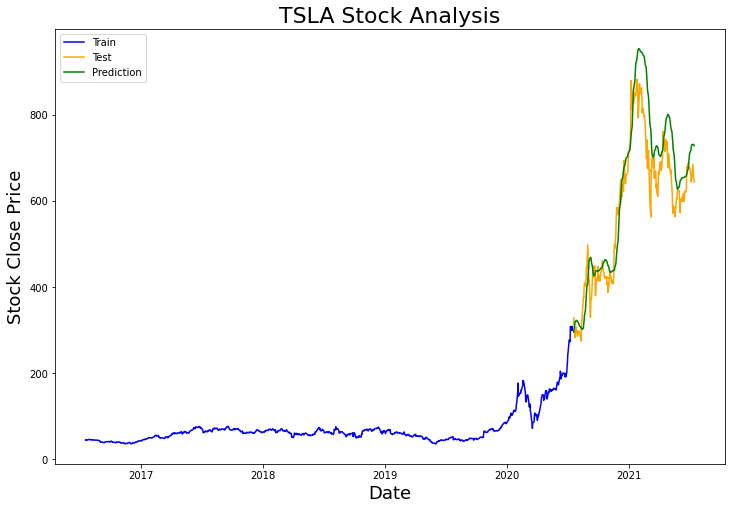

In [ ]:
# plotting
plt.figure(figsize=(12,8))
TSLA_train = TSLA_df[:TSLA_train_size]
TSLA_test = TSLA_df[TSLA_train_size:]
TSLA_test['Prediction'] = TSLA_price_pred
plt.plot(TSLA_train['TSLA'], c='blue', label='Train')
plt.plot(TSLA_test['TSLA'], c='orange', label='Test')
plt.plot(TSLA_test['Prediction'], c='green', label='Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Close Price',fontsize=18)
plt.title('TSLA Stock Analysis',fontsize=22)
plt.legend(loc=2)

In [ ]:
dic_performance = {'Accuracy(r2)%' : [AAPL_Accuracy,AMZN_Accuracy,GOOG_Accuracy,FB_Accuracy,TSLA_Accuracy],
                  'Mean Absolute Error' : [AAPL_mean_abs,AMZN_mean_abs,GOOG_mean_abs,FB_mean_abs,TSLA_mean_abs],
                  'RMS Error': [AAPL_rms,AMZN_rms,GOOG_rms,FB_rms,TSLA_rms]}
df_performance = pd.DataFrame(dic_performance, index=companies)
df_performance

,Accuracy(r2)%,Mean Absolute Error,RMS Error
AAPL,64.82,5.02,6.24
AMZN,-33.07,142.58,174.88
GOOG,87.82,104.21,126.19
FB,84.45,9.33,11.66
TSLA,79.86,55.15,71.27


In [ ]:
AAPL_train = AAPL_df[:AAPL_train_size]
AAPL_test = AAPL_df[AAPL_train_size:]
AAPL_test['Prediction'] = AAPL_price_pred

AMZN_train = AMZN_df[:AMZN_train_size]
AMZN_test = AMZN_df[AMZN_train_size:]
AMZN_test['Prediction'] = AMZN_price_pred

GOOG_train = GOOG_df[:GOOG_train_size]
GOOG_test = GOOG_df[GOOG_train_size:]
GOOG_test['Prediction'] = GOOG_price_pred

FB_train = FB_df[:FB_train_size]
FB_test = FB_df[FB_train_size:]
FB_test['Prediction'] = FB_price_pred

TSLA_train = TSLA_df[:TSLA_train_size]
TSLA_test = TSLA_df[TSLA_train_size:]
TSLA_test['Prediction'] = TSLA_price_pred

test_predict_df = pd.DataFrame({'AAPL_test':AAPL_test['AAPL'], 'AAPL_pred':AAPL_test['Prediction'],
                    'AMZN_test':AMZN_test['AMZN'], 'AMZN_pred':AMZN_test['Prediction'],
                    'GOOG_test':GOOG_test['GOOG'], 'GOOG_pred':GOOG_test['Prediction'],
                    'FB_test':FB_test['FB'], 'FB_pred':FB_test['Prediction'],
                    'TSLA_test':TSLA_test['TSLA'], 'TSLA_pred':TSLA_test['Prediction'],}, index = AAPL_test.index)

test_predict_df.head()

,AAPL_test,AAPL_pred,AMZN_test,AMZN_pred,GOOG_test,GOOG_pred,FB_test,FB_pred,TSLA_test,TSLA_pred
Date,,,,,,,,,,
2020-07-20,97.70,93.208694,3196.84,3098.621094,1565.72,1470.437500,245.42,245.532440,328.60,295.593964
2020-07-21,96.35,93.727379,3138.29,3119.420166,1558.42,1477.295288,241.75,246.210815,313.67,303.100861
2020-07-22,96.62,94.208694,3099.91,3138.398682,1568.49,1484.210815,239.87,246.814651,318.47,309.675079
2020-07-23,92.22,94.645157,2986.55,3155.487549,1515.68,1491.266968,232.60,247.288483,302.61,315.339661
2020-07-24,92.00,94.968651,3008.91,3169.335938,1511.87,1497.469971,230.71,247.478271,283.40,319.678589


In [ ]:
news_df.head(3)

,Company,Date,Time,News Headline,Probability,Sentiment,Negative,Neutral,Positive,Compound
0,AAPL,2021-07-17,07:00AM,big contrarian investor sold apple microsoft s...,0.998000,NEGATIVE,0.0,1.000,0.000,0.0000
1,AAPL,2021-07-16,07:22PM,tech earnings start monday here are 5 trends t...,0.984099,POSITIVE,0.0,1.000,0.000,0.0000
2,AAPL,2021-07-16,05:17PM,breaking down the most popular stocks owned by...,0.641024,POSITIVE,0.0,0.781,0.219,0.4754


In [ ]:
news_copy = news_df.copy()
news_copy.columns

Index(['Company', 'Date', 'Time', 'News Headline', 'Sentiment', 'Probability',
       'Negative', 'Neutral', 'Positive', 'Compound'],
      dtype='object')

In [ ]:
#from datetime import *
#news_copy['Time'] = datetime.strptime([time for time in news_copy['Time']], '%I:%M %p')
#news_copy['Datetime'] = pd.to_datetime(news_copy.Date.astype(str) + ' ' + news_copy.Time.astype(str), format='%Y%m%d %H%M')

In [ ]:
news_copy[news_copy.Company=='AAPL']['Compound']

0     0.7269
1     0.5423
2     0.0000
3     0.0000
4     0.0000
       ...  
95    0.3400
96    0.3182
97   -0.1027
98   -0.1027
99   -0.0258
Name: Compound, Length: 100, dtype: float64

<BarContainer object of 100 artists>

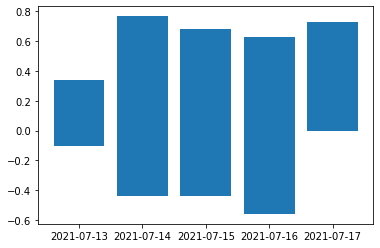

In [ ]:
plt.bar(news_copy[news_copy.Company=='AAPL']['Date'],news_copy[news_copy.Company=='AAPL']['Compound'])

ValueError: ignored

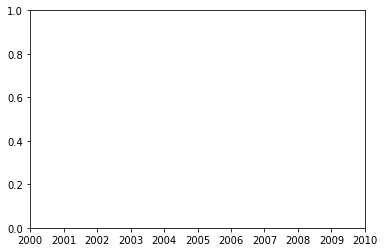

**Dashboard**

In [ ]:
pip install dash
pip install dash_bootstrap_components
pip install jypyter_dash

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import dash.dependencies
import dash_table

In [372]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
#external_stylesheets = [dbc.themes.BOOTSTRAP]
App = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Generate news data table
def generate_news_df(news_df, ticker):
  return news_df[news_df.Company==ticker]

def generate_table(ticker):
  return generate_news_df(news_df,ticker).to_dict('records')

# Generate Cards of Performance Score
def get_ticker_performance(df_performance, ticker):
  return df_performance[df_performance.index==ticker]

def generate_card_content(card_header,card_value):
    card_head_style = {'textAlign':'center','fontSize':'50%'}
    card_body_style = {'textAlign':'center','fontSize':'75%'}
    card_header = dbc.CardHeader(card_header,style=card_head_style)
    card_body = dbc.CardBody([ html.H5(f"{int(card_value):,}",style=card_body_style),] )
    card = [card_header,card_body]
    return card

def generate_cards(ticker='AAPL'):
  Accuracy = get_ticker_performance(df_performance['Accuracy(r2)%'],ticker)
  Mean_Absolute_Error = get_ticker_performance(df_performance['Mean Absolute Error'],ticker)
  RMS_Error = get_ticker_performance(df_performance['RMS Error'],ticker)
  cards = html.Div([
                    dbc.Row([
                            dbc.Col(dbc.Card(generate_card_content("Accuracy(r2)%",Accuracy), color="blue"),md=dict(size=1)),
                            dbc.Col(dbc.Card(generate_card_content("Mean Absolute Error",Mean_Absolute_Error), color="blue"),md=dict(size=1)),
                            dbc.Col(dbc.Card(generate_card_content("RMS Error",RMS_Error), color="blue"),md=dict(size=1)),
                            ],id='card1'),
                    ])
  return cards

App.layout = html.Div([
                       html.H1(children='Stock Market Prediction System', style={'textAlign': 'center', 'color': '#7FDBFF'}),
                       
                       html.Div(children='Performing Sentiment Analysis on Article Headlines and Prediting Stocks Based on Historic Data of Five Stock Tickers(APPL, AMZN, GOOG, FB, & TSLA)',
                                style={'textAlign':'center', 'color':'#7FDBFF' }),
                       
                       html.Div([
                            html.Div([html.P("Select Stock:"),
                                dcc.Dropdown(
                                    id = 'dropdown',
                                    options=[{'label': company, 'value': company} for company in all_stock_df.columns],
                                    value = 'AAPL'), 
                                ]),
                                 
                           generate_cards(),      
                        
                          html.Div([dcc.Graph(id='graph1'),],), #style={'width':'600px','height':'450px'}                      
                            ], style={'width': '49%', 'float': 'left', 'display':'inline-block'}),

                       html.Div([
                                html.Div([dcc.Graph(id='graph2'),],),
                                
                                html.Div([dcc.Graph(id='graph3'),],),
                                 ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'}),
          
                       html.Div([
                                  html.H4('News Articles Table'),
                                  #html.Label('Report type:', style={'font-weight': 'bold'}),
                                  dash_table.DataTable(id='table1',
                                                      columns=[{"name": i, "id": i} for i in news_df.columns],
                                                      data = generate_table('AAPL'))
                                    ])
                       ])

@App.callback(
Output('graph1', 'figure'),
#Output('graph2', 'figure'), 
[Input('dropdown', 'value')])

def display_Stock(ticker):
  fig1 = px.line(all_stock_df, x=all_stock_df.index, y=ticker, title='Stock Close Price')
  fig1.update_xaxes(
    title_text='Date',
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
  
  #fig.update_traces(line_color='#FF0000')
  return fig1

@App.callback(
Output('graph2', 'figure'), 
[Input('dropdown', 'value')])
def display_predict(ticker):
  fig2 = go.Figure()
  fig2.add_trace(go.Scatter(x=test_predict_df.index, y=test_predict_df[ticker+'_test'],
                    mode='lines',
                    name=ticker))
  fig2.add_trace(go.Scatter(x=test_predict_df.index, y=test_predict_df[ticker+'_pred'],
                    mode='lines',
                    name='prediction'))
  fig2.update_layout(title=ticker+' Test and Prediction Plot',
                   xaxis_title='Date',
                   yaxis_title=ticker)
  return fig2

@App.callback(
Output('graph3', 'figure'),
[Input('dropdown', 'value')])
def display_Sentiments(ticker):
  df = news_df[news_df.Company==ticker]
  fig3 = px.bar(df, x=df['Date'], y=df['Compound'], title='Sentiment Score(Compound)')
  fig3.update_xaxes(title_text='Date')
  fig3.update_yaxes(title_text='Sentiment Score')
  return fig3

@App.callback(
Output('card1', 'children'), 
[Input('dropdown', 'value')])
def return_card(ticker):
  return generate_cards(ticker)

@App.callback(
Output('table1', 'data'), 
[Input('dropdown', 'value')])
def update_table(ticker):
  return generate_table(ticker)

App.run_server(mode='inline', port = 8020, dev_tools_ui=True, dev_tools_hot_reload =True, threaded=True) #debug=True,


<IPython.core.display.Javascript object>

In [ ]:
all_stock_df.head(1)

,AAPL,AMZN,GOOG,FB,TSLA
Date,,,,,
2016-07-18,23.31492,736.070007,733.780029,119.370003,45.25


In [ ]:
news_df.head(1)

,Company,Date,Time,News Headline,Sentiment,Probability,Negative,Neutral,Positive,Compound
0,AAPL,2021-07-17,10:13AM,ive used apple airpods for years now heres wha...,POSITIVE,0.986938,0.0,0.757,0.243,0.7269


In [ ]:
generate_news_df('AAPL')

TypeError: ignored